# Project: Investigating the TMDb movie data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> **Using the TMDb movie data**:                               
This data set contains information about 10,000 movies collected from The Movie Database (TMDb)          
(cleaned from original data on Kaggle - https://www.kaggle.com/tmdb/tmdb-movie-metadata )              
                       
I will be looking at the genres of the movies and seeing if a genre's popularity changes over time.
                        
1. What are the different genres ?               
2. How many movies are there for each genre ?                   
3. Does the number of movies of each genre change over time ?                     
  (does the number of movies of a specific genre increase, stay the same or decrease from year to year) ?             
4. How many votes does each genre get ?           
5. What was the average vote per genre
6. Does the number of votes for each genre change over time ?                            
  (this is not the same as question 3. The number of Action movies may stay the same year to year, but they may recieve more votes in the TMDb database)                
7. Are there more votes in the later years ?                 
8. Do certain genres show up more in certain months ?              

In [40]:
# import statements 

import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

# this allows us to have multiple outputs in one cell 
# https://volderette.de/jupyter-notebook-tip-multiple-outputs/
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# http://ipython.readthedocs.io/en/stable/interactive/magics.html
%matplotlib inline

# How do you change the size of figures drawn with matplotlib?
# https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib 
# https://towardsdatascience.com/all-your-matplotlib-questions-answered-420dd95cb4ff

# How do I set the figure title and axes labels font size in Matplotlib?
# https://stackoverflow.com/questions/12444716/how-do-i-set-the-figure-title-and-axes-labels-font-size-in-matplotlib

In [41]:
# we will priint certain things only if debugging is True

#debugging = True
debugging = False


<a id='wrangling'></a>
## Data Wrangling

> load in the data, check for cleanliness, and then trim and clean the dataset for analysis. 

In [42]:
print(datetime.now())

df = pd.read_csv("tmdb-movies.csv")

print(datetime.now())

2019-08-07 01:28:56.571692
2019-08-07 01:28:56.673338


### General Properties

In [43]:
if debugging: 
    print(datetime.now())
    
    df.head(2)
    
    print(datetime.now()) 

> as noted in the data description page the genres are separated by the pipe symbol |

In [44]:
if debugging:
    print(datetime.now())
    
    df.info()
    
    print(datetime.now())

> some genres entries are NULL

In [45]:
if debugging:
    print(datetime.now())
    
    df.describe()
    
    print(datetime.now())

In [46]:
if debugging:
    print(datetime.now())
    
    df.dtypes
    
    print(datetime.now())

> The popularity field seemed like it might be interesting. So I checked the kaggle page and did a web search, but discovered its a rating of how many times the movie's page was viewed the past week on the site.              
So I really don't see how its useful at all or why its even included in the dataset.        
If they had a history of the popularity so we could see how it changed week to week that might be interesting, but having one value for one week seems utterly useless.

### Data Cleaning 
> Each movie can have multiple genres. If it does then its genres will be separated by the pipe symbol |              
So we're going to split the genres into separate fields and then combine them into one long column.

In [47]:
print(datetime.now())

# create a dataframe that contains just the movie id and its corresponding genres

genres_df = df[["id", "genres"]]

if debugging:
    genres_df.head(5)

print(datetime.now())    

2019-08-07 01:28:57.140089
2019-08-07 01:28:57.142023


In [48]:
print(datetime.now())

# now split the genres into individual columns 
genres_split_df = genres_df["genres"].str.split("|", expand=True)

if debugging: 
    genres_split_df.head()

print(datetime.now())

2019-08-07 01:28:57.235819
2019-08-07 01:28:57.274449


In [49]:
print(datetime.now())

# since both the unsplit and split genre dataframes have the same indices we can join them together 
genres_df = pd.concat( [genres_df, genres_split_df], axis=1, join="inner" )

if debugging: 
    genres_df.head(3)
    
print(datetime.now())    

2019-08-07 01:28:57.333537
2019-08-07 01:28:57.335533


> We can see there are at most 5 genres. (columns 0 through 4)

In [50]:
print(datetime.now())    

# now we want to combine genre columns 0 through 4 into a single genre column 
# we'll use a list comprehension to create 5 dataframes 
# and then concat them into a single dataframe 

genres_df = pd.concat ( 
    [
        pd.DataFrame( 
            { "id": genres_df["id"], "genre": genres_df[i] } 
        )
        for i in range(5)
    ] 
)

if debugging: 
    genres_df.head()

print(datetime.now())        

2019-08-07 01:28:57.440758
2019-08-07 01:28:57.445749


In [51]:
print(datetime.now())    

# we saw in the split genres dataframe that there were at most 5 genres (0 through 4)
# so now that we've combined them into one column we can  
# check and see if the number of rows in the genres dataframe 
# is equal to 5 times the number of rows in the original dataframe 

df.shape[0] * 5 == genres_df.shape[0] 

print(datetime.now())    

2019-08-07 01:28:57.558647


True

2019-08-07 01:28:57.565640


In [52]:
print(datetime.now())  

# compare the genres in the first row of the original dataframe with the genres in the genre dataframe 
# test and make sure the movie id and genres match 

df.iloc[0][["id", "genres"]]

genres_df.query( "id == {}".format(df.iloc[0]["id"]) )

print(datetime.now())  

2019-08-07 01:28:57.653972


id                                           135397
genres    Action|Adventure|Science Fiction|Thriller
Name: 0, dtype: object

,id,genre
0,135397,Action
0,135397,Adventure
0,135397,Science Fiction
0,135397,Thriller
0,135397,None


2019-08-07 01:28:57.667934


In [53]:
print(datetime.now())  

# many of the movies did not have 5 genres 
# so when we split the genre field we filled those spaces with None 
# so let's keep only those that are valid values

genres_df.shape

criteria = genres_df["genre"].notna()

genres_df = genres_df[criteria]

genres_df.shape

print(datetime.now())  

2019-08-07 01:28:57.748941


(54330, 2)

(26960, 2)

2019-08-07 01:28:57.757953


In [54]:
print(datetime.now()) 

# now join the genre dataframe back to the original dataframe 
# we can do this since the indicies haven't changed in either dataframe 
    
df_columns = ["id", "original_title", "runtime", "vote_count", "vote_average", "release_year", "release_date"]
joined_df = df[df_columns].join(genres_df["genre"])

if debugging: 
    joined_df.head(3)
    joined_df.dtypes
    
print(datetime.now()) 

2019-08-07 01:28:57.858634
2019-08-07 01:28:57.889576


In [55]:
print(datetime.now()) 

# add a release_month column to the dataframe
joined_df["Month"] = pd.to_datetime(joined_df["release_date"]).dt.month

if debugging: 
    joined_df.head(3)
    joined_df.dtypes

print(datetime.now()) 

2019-08-07 01:28:57.976074
2019-08-07 01:28:59.607808


In [56]:
print(datetime.now()) 

# don't need this anymore
joined_df.drop(columns=["release_date"], inplace=True)

print(datetime.now()) 

2019-08-07 01:28:59.612698
2019-08-07 01:28:59.624687


<a id='eda'></a>
## Exploratory Data Analysis

> We finally have a dataframe with a single genre in each column.
This will make it easier to group by genre and explore the data.               

### Q1: What are the different genres ?  
### Q2: How many movies are there for each genre ?

In [57]:
print(datetime.now())

genre_counts = joined_df["genre"].value_counts()
genre_counts

print(datetime.now())

2019-08-07 01:28:59.797286


Drama              4761
Comedy             3793
Thriller           2908
Action             2385
Romance            1712
Horror             1637
Adventure          1471
Crime              1355
Family             1231
Science Fiction    1230
Fantasy             916
Mystery             810
Animation           699
Documentary         520
Music               408
History             334
War                 270
Foreign             188
TV Movie            167
Western             165
Name: genre, dtype: int64

2019-08-07 01:28:59.818595


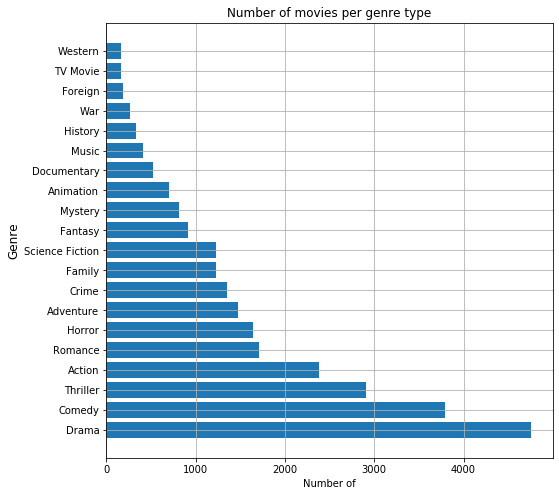

In [58]:
plt.figure(figsize=(8, 8)) # width, height
plt.title('Number of movies per genre type')  
plt.xlabel('Number of', fontsize=10)
plt.ylabel('Genre', fontsize=12)
plt.grid() 

plt.barh(genre_counts.index.values, genre_counts.values);

> So overall, for the entire time covered by the database, Dramas are the type of movie that show up most often.         
Foreign movies, movies based on TV Movies, and Western movies show up the least often.

### Q3: Does the number of movies of each genre change over time ?

In [59]:
print(datetime.now())

a3 = joined_df.groupby(["genre", "release_year"]).size()

if debugging:
    a3

print(datetime.now())

2019-08-07 01:29:01.145274
2019-08-07 01:29:01.150261


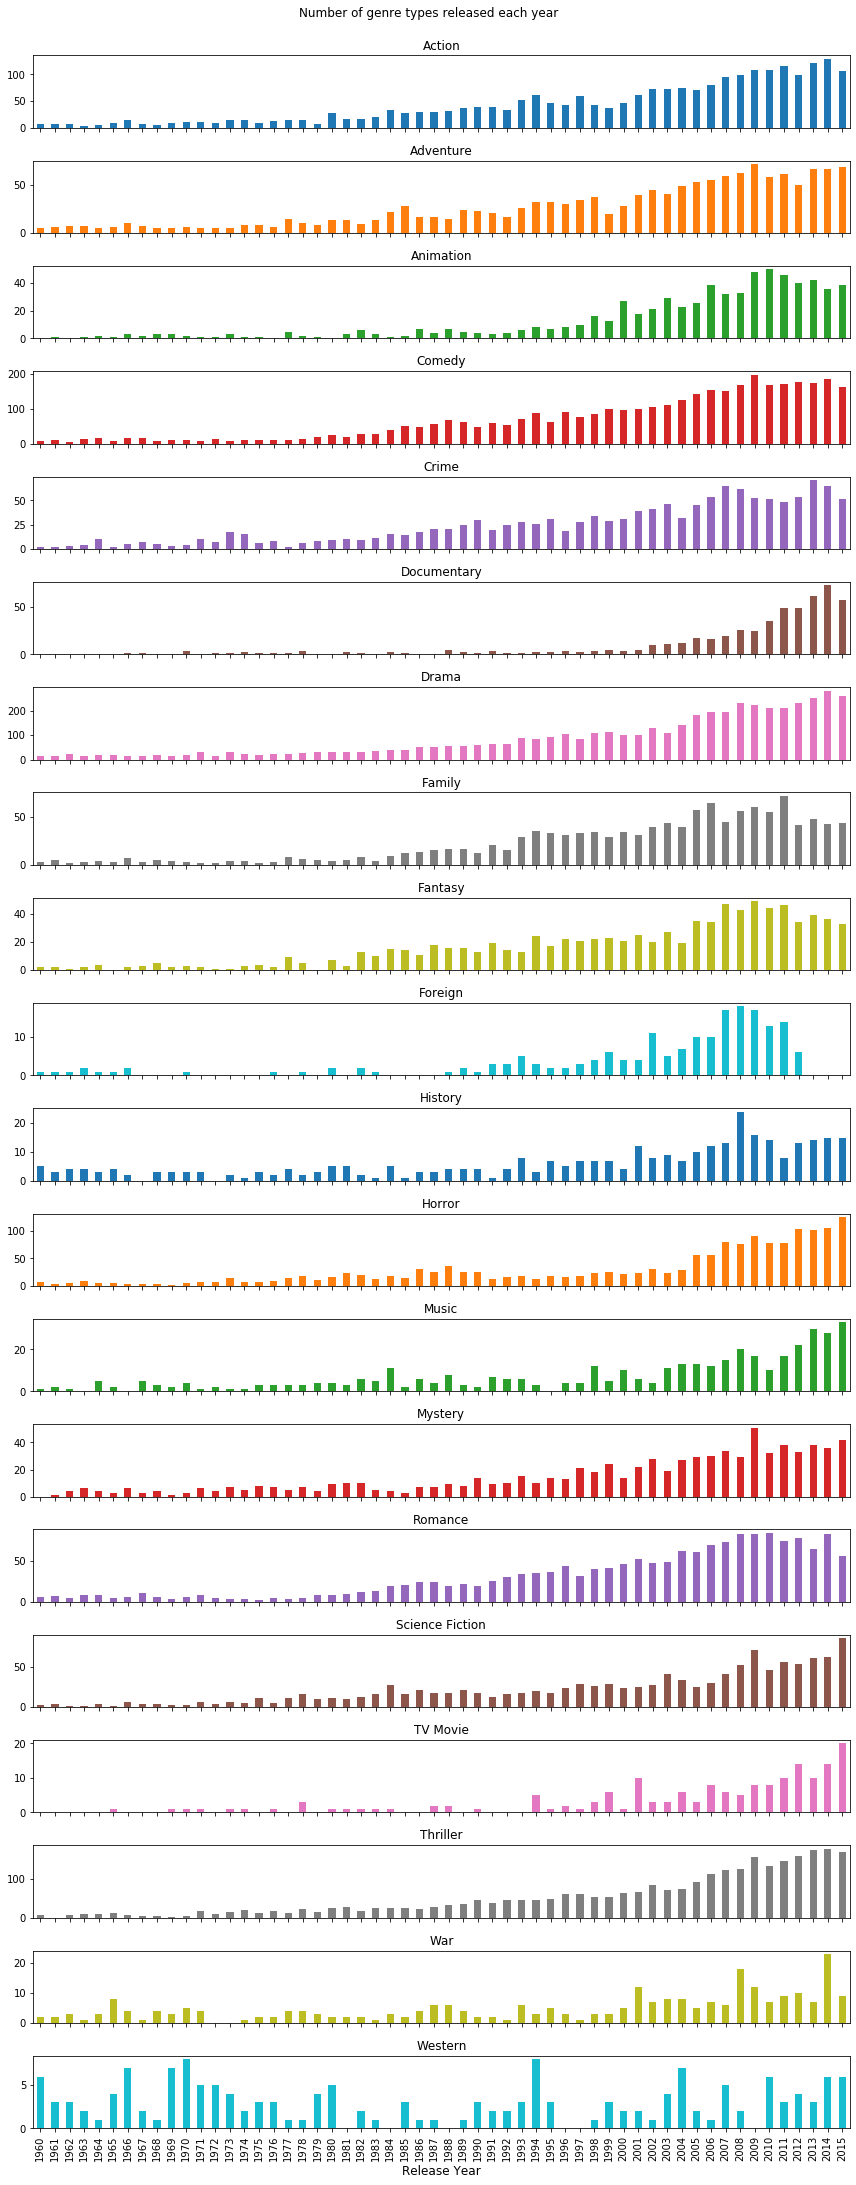

In [60]:
a3.unstack(level=0).plot(kind='bar', subplots=True, legend=None, figsize=(12, 30));
plt.xlabel('Release Year', fontsize=12);
plt.suptitle("Number of genre types released each year", y=1.01, fontsize=12)
plt.tight_layout();
#plt.show();

> It looks like every genre, except for War and Western, sees an increase over time.            
Both War and Western bounce up and down over time.                      
      
A second (but more crowded) way to view the change over time is to place all genres on the same chart.               

In [61]:
print(datetime.now())

a3_pivot = a3.reset_index()

if debugging:
    a3_pivot

a3_pivot = a3_pivot.pivot(index='release_year', columns='genre', values=0)

if debugging:
    a3_pivot

print(datetime.now())

2019-08-07 01:29:08.466192
2019-08-07 01:29:08.472186


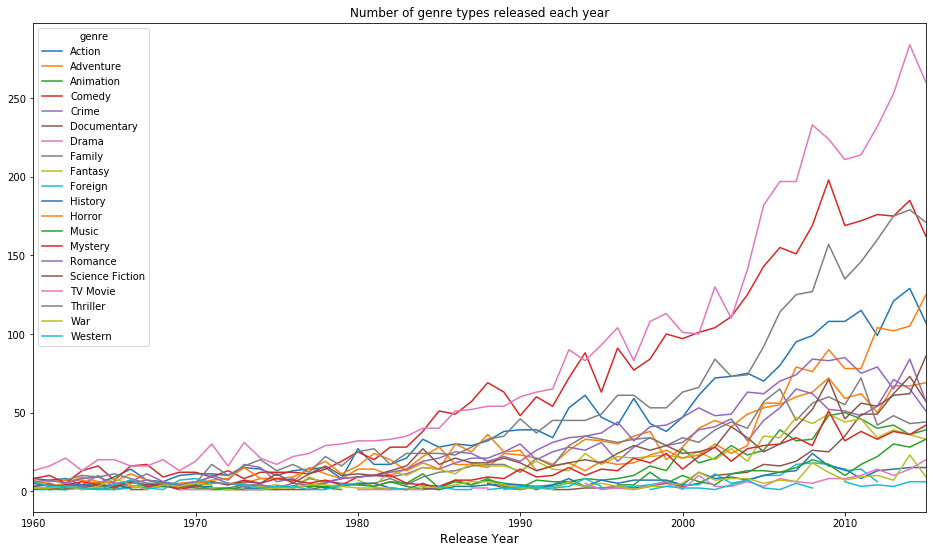

In [62]:
a3_pivot.plot(figsize=(16, 9), title='Number of genre types released each year');
plt.xlabel('Release Year', fontsize=12);

### Q4: How many votes does each genre get ?

In [63]:
print(datetime.now())

a4 = joined_df.groupby(["genre"])["vote_count"].sum()
a4 = a4.sort_values(ascending=False, inplace=False)
a4

print(datetime.now())

2019-08-07 01:29:09.428097


genre
Action             937007
Drama              869022
Adventure          754807
Thriller           742803
Comedy             669223
Science Fiction    537301
Fantasy            385399
Crime              377612
Family             335227
Romance            284313
Animation          211797
Horror             196538
Mystery            191969
War                 73098
History             61380
Music               50731
Western             33947
Documentary         18255
TV Movie             5739
Foreign              3126
Name: vote_count, dtype: int64

2019-08-07 01:29:09.436077


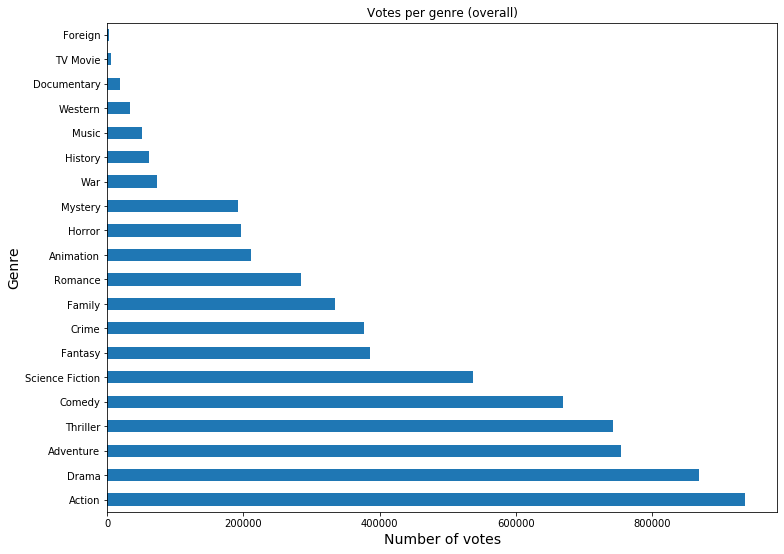

In [64]:
a4.plot(kind="barh", figsize=(12, 9), title='Votes per genre (overall)');
plt.xlabel('Number of votes', fontsize=14);
plt.ylabel('Genre', fontsize=14);

> We can see that even though we previously showed that Dramas were the most often occuring genre, Action movies had the most votes. 

### Q5: But what was the average vote per genre ?

In [65]:
print(datetime.now())

a5 = joined_df.groupby(["genre"])["vote_average"].mean()
a5 = a5.sort_values(ascending=False, inplace=False)
a5

print(datetime.now())

2019-08-07 01:29:09.776767


genre
Documentary        6.908462
Music              6.480392
History            6.410479
Animation          6.403147
War                6.297778
Drama              6.165301
Crime              6.124059
Western            6.083030
Romance            6.042874
Family             5.997563
Foreign            5.981383
Mystery            5.946790
Adventure          5.940585
Comedy             5.905167
Fantasy            5.863537
TV Movie           5.788024
Action             5.787421
Thriller           5.750413
Science Fiction    5.665041
Horror             5.337447
Name: vote_average, dtype: float64

2019-08-07 01:29:09.781754


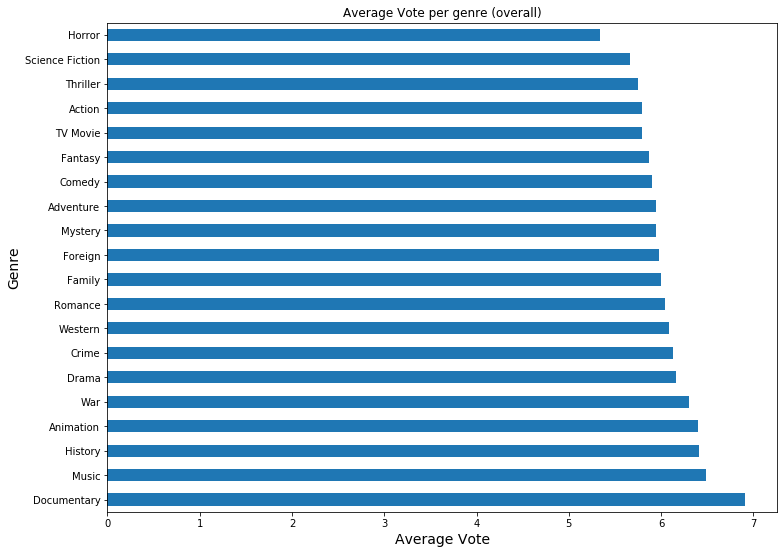

In [66]:
a5.plot(kind="barh", figsize=(12, 9), title='Average Vote per genre (overall)');
plt.xlabel('Average Vote', fontsize=14);
plt.ylabel('Genre', fontsize=14);

> Surprisingly Documentaries have the highest average vote.                  
Even War movies rate higher than Drama of Action.

### Q6: Does the number of votes for each genre change over time ?

In [67]:
print(datetime.now())

a6 = joined_df.groupby(["genre", "release_year"])["vote_count"].sum()

if debugging:
    a6
    
print(datetime.now())    

2019-08-07 01:29:10.112245
2019-08-07 01:29:10.117230


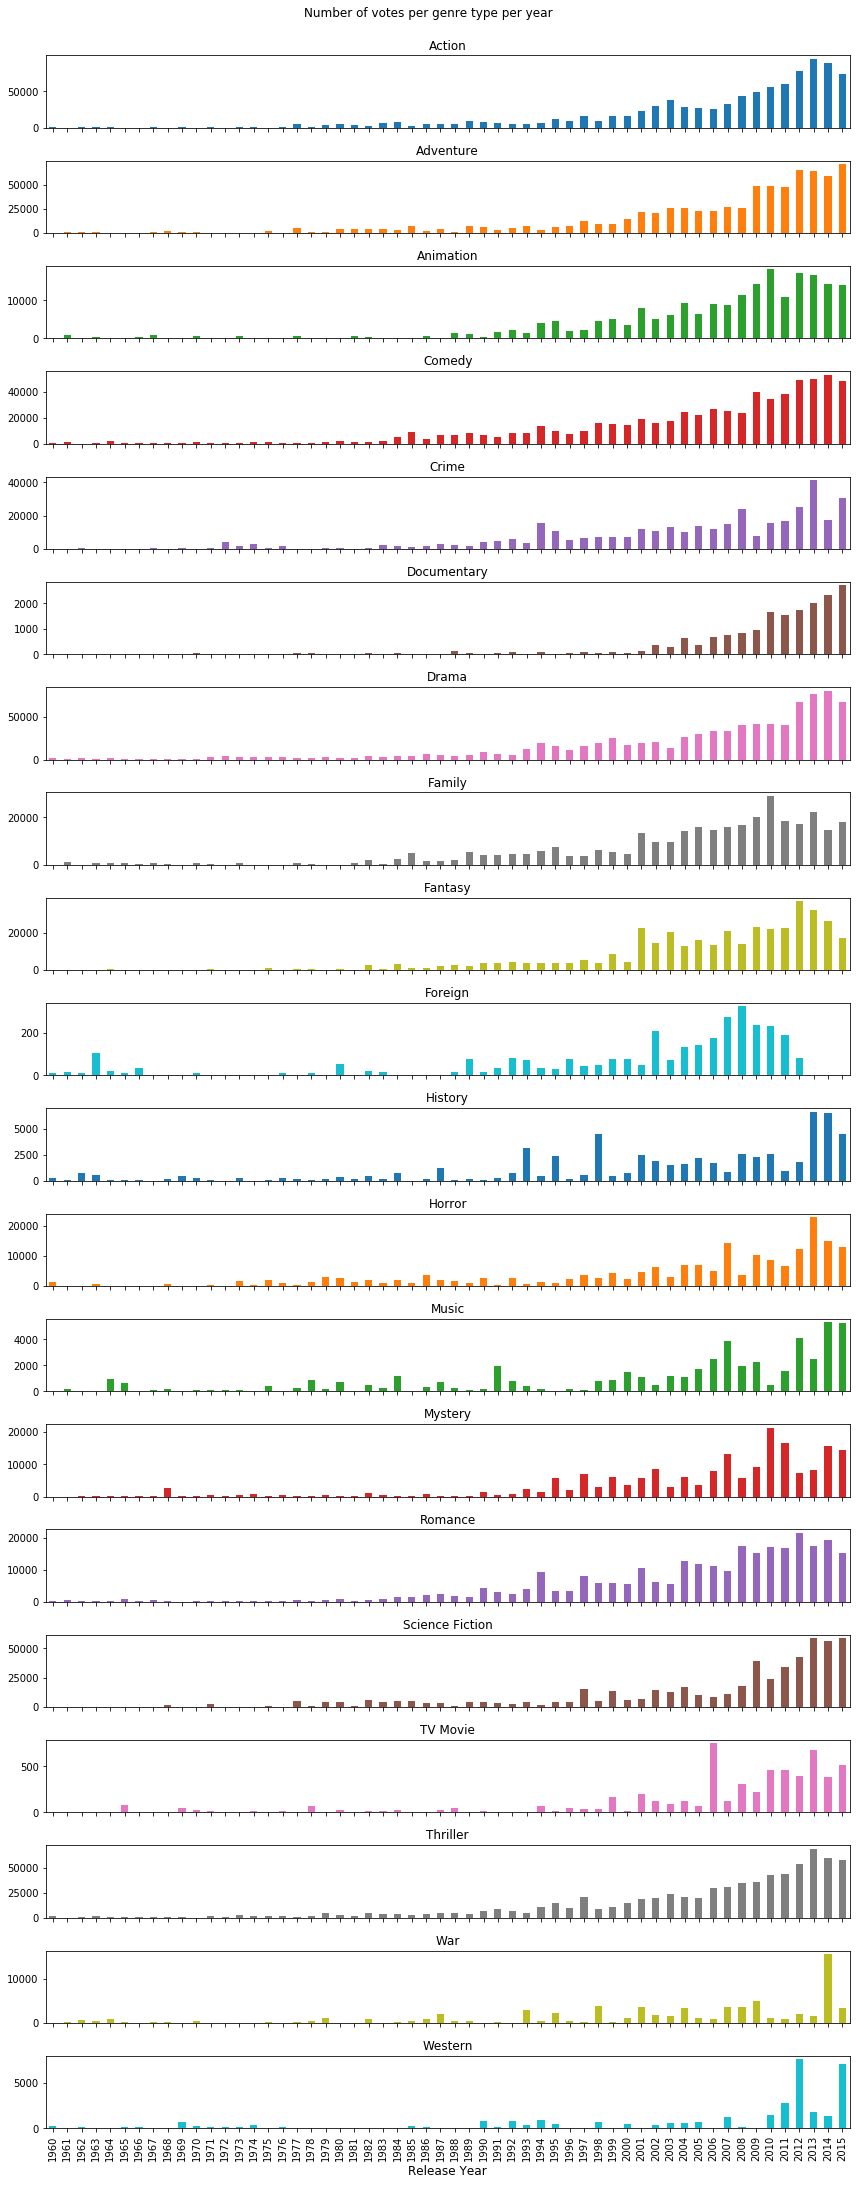

In [68]:
a6.unstack(level=0).plot(kind='bar', subplots=True, legend=None, figsize=(12, 30));
plt.xlabel('Release Year', fontsize=12);
plt.suptitle("Number of votes per genre type per year", y=1.01, fontsize=12)
plt.tight_layout();
plt.show();

> The most interesting about this is the TV Movie genre that was rated so highly in 2006 and the War movie genre rated so highly in 2014. But overall this shows us what we've come to expect: there is generally an increase for all genres as time goes on.  


In [69]:
print(datetime.now())    

if debugging:
    joined_df [ (joined_df["genre"]=="TV Movie") & (joined_df["release_year"]==2006) ]
    joined_df [ (joined_df["genre"]=="War") & (joined_df["release_year"]==2014) ]
    
print(datetime.now())    

2019-08-07 01:29:16.920337
2019-08-07 01:29:16.920337


In [70]:
print(datetime.now()) 

a7 = joined_df.groupby(["release_year"])["vote_count"].sum()

if debugging: 
    a7

print(datetime.now()) 

2019-08-07 01:29:17.111879
2019-08-07 01:29:17.114876


### Q7: Are there more votes in the later years ?

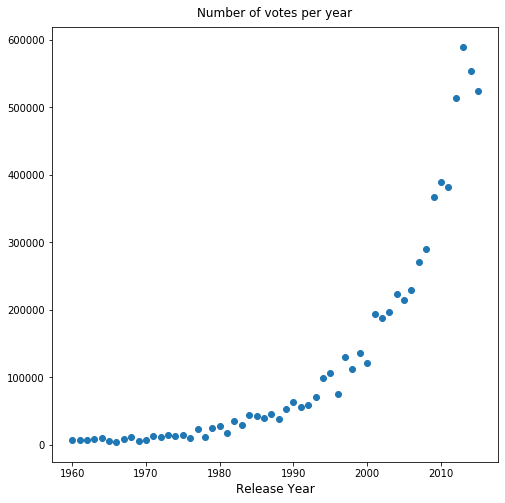

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8));

x = a7.index.values
y = a7.values

plt.xlabel('Release Year', fontsize=12);
plt.title("Number of votes per year", y=1.01, fontsize=12);

axes.scatter(x, y);

> Yes. This shows that movies released in the later years have more votes.                  
I guess people voting on that web site don't generally like to watch old movies.

### Q8: Do certain genres show up more in certain months ?

In [72]:
print(datetime.now()) 

a8 = joined_df.groupby(["genre", "Month"]).size()

if debugging: 
    a8

print(datetime.now()) 

2019-08-07 01:29:17.351682
2019-08-07 01:29:17.356668


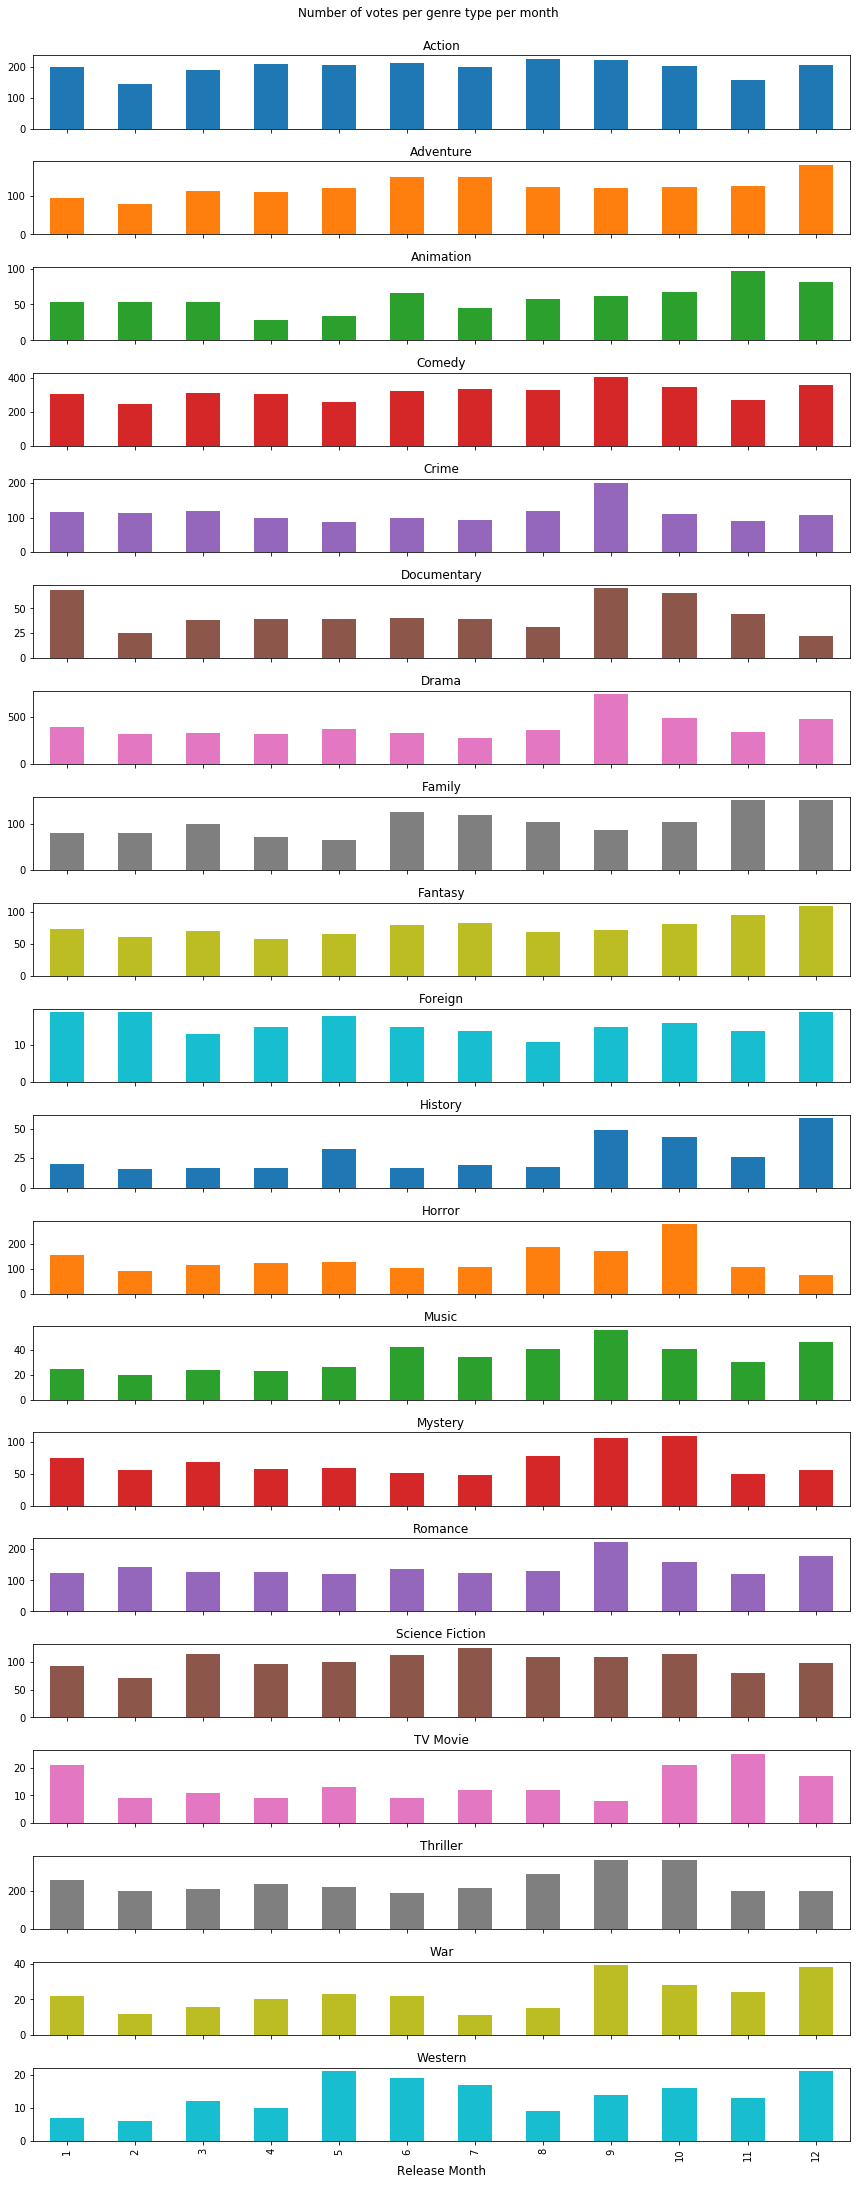

In [73]:
a8.unstack(level=0).plot(kind='bar', subplots=True, legend=None, figsize=(12, 30));
plt.xlabel('Release Month', fontsize=12);
plt.suptitle("Number of votes per genre type per month", y=1.01, fontsize=12)
plt.tight_layout();
plt.show();

> Yes. As expected Horror movies, Mysteries, and Thrillers show up the msot in October (Halloween).         
But surprisingly, Romance movies do NOT show up most often in February (Valentine's Day).       
They show up most often in September. Perhaps movie makers are trying to attract the "back to school" crowd, knowing that students will be asking each other on dates.

<a id='conclusions'></a>
## Conclusions

The genres field has some problems when it comes to data analysis. You would hope that the movie's director or studio would be the one determining the genre of each movie, but according to kaggle               

* All fields are filled out by users so don't expect them to agree on keywords, genres, ratings, or the like.    

So the users of the web site filled in the genre of each movie and sometimes they chose more than one genre. Looking through the data it looks like the users did a pretty good job assigning genres, but there are some questionable choices (in my opinion).          
               
For example:               
1. "Tremors" starring Kevin Bacon is classified as Action|Horror. Why ? Why not Action|Thriller ? Or Action|Science Fiction ? 
2. "8 Mile" starring Eminem is classified as Drama instead of Drama|Music             
3. "Abraham Lincoln vs. Zombies" is Horror|Action|Thriller while "Abraham Lincoln: Vampire Hunter" is Action|Horror|Fantasy       
4. "The Sixth Sense" is listed as Mystery|Thriller|Drama. It seems like Science Fiction or Horror should be there too.      

Also the ability of movies to have multiple genres makes analysis confusing. Can we really say there are twice as many Family genre movies as there are Animation genre movies, when just about every Animation movie is also listed as Family ?

It does seem to make sense that newer movies would have more votes than older movies.

It also makes sense that Horror, Science Fiction, Thriller movies would be released in the same month as Halloween.     

The most surprising thing was that Romance movies are not most often released in the same month as Valentine's sDay, but instead are most numersous in September.


In [74]:
print(datetime.now()) 

print("finished") 

print(datetime.now()) 

2019-08-07 01:29:20.886464
finished
2019-08-07 01:29:20.886464
